## **REDUCED BASIS SPACE**

#### LOAD LIBRARIES

In [1]:
# Pulizia
from IPython import get_ipython
get_ipython().magic('clear')
get_ipython().magic('reset -f')


# Import libraries:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import itertools
import time
import sys
import h5py
import os
import shutil

# Import user defined libraries:
from FreeFEM import FFmatrix_fread, FFvector_fread

#model_files folder is created
folder_name = 'model_files'
if os.path.exists(folder_name):
    shutil.rmtree(folder_name)      #delete the folder if exist
os.makedirs(folder_name)            #create a new folder


/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_5394/269933209.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')
/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_5394/269933209.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


#### DEFINE REFERENCE PROBLEM PARAMETERS

In [2]:
## Define universal constants:
N_AVOG = 6.022141E+23  # [-]
N_BOLT = 1.380649E-23  # [-]

# Define geometrical parameters:
RADIUS = 1.00E-05  # [m]
LENGTH = 1.00E-03  # [m]

# Define sources intensity:
FISSION_RATE = 3.00E+19                 # Per T [fissions/s] per c [fissions/m^3 s]
#q''' = 3.21e-11                       #[W/m^3]
#rho = 11040                           #[Kg/m^3]
#Cp = 400                              #[J/(Kg K)]
FISSION_HEAT = 7.27E-18                 #[K/fissions]    = q'''/(rho Cp)
FISSION_YIELD = 0.24E+00                #Xenon [at/fissions]  
SOURCE_T = FISSION_RATE * FISSION_HEAT   #[K/s]
SOURCE_C = FISSION_RATE * FISSION_YIELD  #[atm / (m^3 s)]

# Define temperatur diffusion coefficient and forcing dimensionless group:
#k = 2.5 E-05                          #[W/(m K)]
ALPHA_T = 5.00E-07                     # [m^2 / s]   # = k/(rho Cp)
GAMMA_T = SOURCE_T * LENGTH**2 / ALPHA_T  # [ - ]
                       
# Define reference temperature, concentration and linear diffusion parameters:
T_BC, T_IC = 2.00E+03, 2.00E+03  # [K]
C_BC, C_IC = 0.00E+00, 0.00E+00  # [atm / m^3]

# Define forcing dimensionless group:
GAMMA_T = SOURCE_T * LENGTH**2 / ALPHA_T

# Define final time, time increment:
TIME_FINAL = 1.00E+07  # [s]
TIME_DELTA = 1.00E+04  # [s]

# Compute number of iterations:
N_ITER = int(TIME_FINAL / TIME_DELTA)  # [-]

# Define function evaluating the concentration diffusion coefficient at given z coordinated provided the problem parameters:
def ALPHA_C(ZZ, T_BC=T_BC, GAMMA_T=GAMMA_T, FISSION_RATE=FISSION_RATE):
    return 7.60E-10 * np.exp(- 4.86E-19 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2) / N_BOLT) + \
           5.64E-25 * np.exp(- 1.91E-19 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2) / N_BOLT) * np.sqrt(FISSION_RATE) + \
           8.00E-40 * FISSION_RATE

#### IDENTIFY DIRICHLET DOFS AND INTERNAL DOFS

In [3]:
# Load coordinates:
coordinates_Px = FFvector_fread('vv_cc_Px.btxt')
coordinates_Pq = FFvector_fread('vv_cc_Pq.btxt')

# Identify degrees of freedom of the Px and Pq spaces:
sFO_Px = coordinates_Px.shape[0]
sFO_Pq = coordinates_Pq.shape[0]

# Define vector of all Px indeces:
mask_all = np.arange(sFO_Px, dtype=int)

# Identify indeces of the top, bottom and middle boundaries in Px:
mask_inf_bc = mask_all[np.isclose([coordinates_Px[ii, 2] for ii in range(sFO_Px)], np.zeros((sFO_Px)))]
mask_sup_bc = mask_all[np.isclose([coordinates_Px[ii, 2] for ii in range(sFO_Px)], np.ones((sFO_Px)))]
mask_mid_bc = mask_all[np.isclose([np.linalg.norm(coordinates_Px[ii, :2]) for ii in range(sFO_Px)], np.ones((sFO_Px)))]

# Identify indeces of the Dirichlet b.c. for the temperature and concentration field:
mask_bc_T = np.fromiter(set(mask_sup_bc), int)
mask_bc_C = np.fromiter(set(mask_sup_bc) | set(mask_mid_bc) | set(mask_inf_bc), int)

# Identify indeces of the interior for the temperature and concentration field:
mask_in_T = [ii for ii in mask_all if ii not in mask_bc_T]
mask_in_C = [ii for ii in mask_all if ii not in mask_bc_C]

#### DEFINE FINITE ELEMENT ESSENTIALS

In [4]:
# Import mass matrices on the Px and on the Pq space:
mass_Px = FFmatrix_fread('ww_mm_Px.btxt')
mass_Pq = FFmatrix_fread('ww_mm_Pq.btxt')

# Compute volume of the domain:
volume = mass_Px.dot(np.ones(sFO_Px)).dot(np.ones(sFO_Px))

# Extract integration weights and diagonal matrix with their inverse:
weights_Pq = mass_Pq.diagonal()
project_Pq = sparse.diags(np.reciprocal(weights_Pq))

# Import map from Px to Pq and to the dx, dy, dz derivative evaluated in Pq:
PxtoPquu_C = project_Pq.dot(FFmatrix_fread('ww_uu_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdx_C = project_Pq.dot(FFmatrix_fread('ww_dx_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdy_C = project_Pq.dot(FFmatrix_fread('ww_dy_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdz_C = project_Pq.dot(FFmatrix_fread('ww_dz_Px_Pq.btxt')[:, mask_in_C])

# Assemble mass matrix and projected forcing term:
forc_C = PxtoPquu_C.T.dot(weights_Pq[:, None])
mass_C = PxtoPquu_C.T.dot(PxtoPquu_C.multiply(weights_Pq[:, None]))
inte_C = mass_Px.dot(np.ones((sFO_Px)))[mask_in_C] / volume

# Assemble a function assembling the stiffness matrix at a given time:
stiff_C = PxtoPqdx_C.T.dot(PxtoPqdx_C.multiply(ALPHA_C(coordinates_Pq[:, 2:3]) / RADIUS**2 * weights_Pq[:, None])) + \
          PxtoPqdy_C.T.dot(PxtoPqdy_C.multiply(ALPHA_C(coordinates_Pq[:, 2:3]) / RADIUS**2 * weights_Pq[:, None])) + \
          PxtoPqdz_C.T.dot(PxtoPqdz_C.multiply(ALPHA_C(coordinates_Pq[:, 2:3]) / LENGTH**2 * weights_Pq[:, None]))

#### DEFINE PARAMETERS TRAINING SET
$\Xi_{train}$

In [5]:
# Define size of the training parameter set:
sTR = 10000

# Define parameters ranges:
MIN_FR, MAX_FR = 2.00E+19, 3.00E+19 
MIN_BC, MAX_BC = 1.75E+03, 2.5E+03
MIN_LL, MAX_LL = 0.75E-3, 1.25E-3
MIN_RR, MAX_RR = 0.75E-5, 1.25E-5
#MIN_FY, MAX_FY = 0.00, 0.3 
#MIN_Q, MAX_Q =                                                             #q''' [W/m^3]
#MIN_RHO, MAX_RHO =                                                         #rho[Kg/m^3]
#MIN_CP, MAX_CP =                                                           #Cp[J/(Kg K)]
#MIN_FH , MAX_FH = MIN_Q/(MIN_RHO*MIN_CP), MAX_Q/(MAX_RHO*MAX_CP)           #fission heat
#MIN_K, MAX_K =                                                             #[W/(m K)]
#MIN_ALPHA, MAX_ALPHA = MIN_K/(MIN_RHO*MIN_CP), MAX_K/(MAX_RHO*MAX_CP)      #k/(rho Cp)
MIN_GG, MAX_GG = (7.27E-18 / 5.00E-07) * MIN_FR * MIN_LL**2, (7.27E-18 / 5.00E-07) * MAX_FR * MAX_LL**2
#MIN_GG, MAX_GG = (MIN_FH / MIN_ALPHA) * MIN_FR* MIN_LL**2,   (MAX_FH / MAX_ALPHA) * MAX_FR* MAX_LL**2

# Compute a list of random parameters within the range:
LIST_FR = np.random.uniform(low=MIN_FR, high=MAX_FR, size=(sTR))
LIST_BC = np.random.uniform(low=MIN_BC, high=MAX_BC, size=(sTR))
LIST_LL = np.random.uniform(low=MIN_LL, high=MAX_LL, size=(sTR))
LIST_RR = np.random.uniform(low=MIN_RR, high=MAX_RR, size=(sTR))
LIST_GG = (7.27E-18 / 5.00E-07) * LIST_FR * LIST_LL**2

# Extract z coordinates from the list of all Pq points coordinates and map those coordinates to the Pq points:
ZZ = np.sort(list(set(coordinates_Pq[:, 2])))
ZZ_1Dto3D = sparse.csr_matrix(np.array([coordinates_Pq[:, 2] == ZZ[kk] for kk in range(len(ZZ))]).T) * 1

# Compute a training set of concentration diffusion coefficients evaluated at the z coordinates: 
TRAINING = np.empty((len(ZZ), sTR))
for ii in range(sTR):
    TRAINING[:, ii] = ALPHA_C(ZZ, T_BC=LIST_BC[ii], GAMMA_T=LIST_GG[ii], FISSION_RATE=LIST_FR[ii])

#### CONSTRUCT AN AFFINE DECOMPOSITION FOR THE CONCENTRATION DIFFUSION COEFFICIENTS

Ora costruiamo le basi $\zeta_i(\mathbf{x})$

In [6]:
# Compress the training set using singular value decomposition:
UU, SS, VV = np.linalg.svd(TRAINING @ TRAINING.T, full_matrices=False)
NN = np.sum(np.sqrt([np.sum(SS[ii:]) / np.sum(SS) for ii in range(len(SS))]) > 1e-6) + 1 

# Construct 1D and 3D basis for the concentration diffusion coefficient:
BASIS_D_1D = UU[:, :NN]
BASIS_D_3D = ZZ_1Dto3D @ BASIS_D_1D

# Use a greedy algorithm to identify the points (indeces) to interpolate the exact concentration coefficients:
INT_COO = [np.argmax(np.abs(BASIS_D_1D[:, 0]))]
for ii in range(1, NN):
    INT_COO.append(np.argmax(np.abs(BASIS_D_1D[:, ii] - BASIS_D_1D[:, :ii] @ np.linalg.solve(BASIS_D_1D[INT_COO, :ii],  BASIS_D_1D[INT_COO, ii]))))

# Extrat the z coordinates associated with the selected indeces: CO = indici sul vettore delle posizioni.   
INT_COO = np.array(INT_COO)
INT_CZZ = np.array([ZZ[INT_COO[ii]] for ii in range(NN)])

# Define interpolation operator mapping from the diffusion coefficient evaluated in the interpolation points to the linear combination coefficients:
mapDAtoCO = np.linalg.solve(BASIS_D_1D[INT_COO, :], np.eye(NN))

# Estimate the absolute and relative errors committed with this interpolation approach:
ABS_ERR = np.linalg.norm(TRAINING - BASIS_D_1D @ mapDAtoCO @ TRAINING[INT_COO, :], axis=0) 
REL_ERR = ABS_ERR / np.linalg.norm(TRAINING, axis=0)

# Print maximum error:
print(np.max(REL_ERR))
print(VV.shape)

4.5747082055746313e-07
(190, 190)


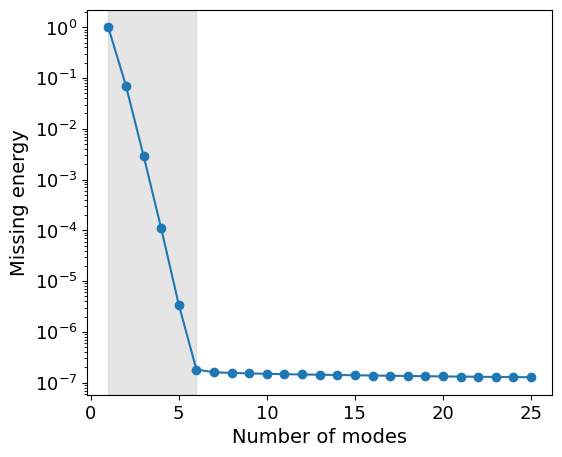

In [7]:
#guardiamo la missing energy del termine non-affine -> queste basi ridotte dopo le usiamo per davvero
missing = np.sqrt([np.sum(SS[ii:]) / np.sum(SS) for ii in range(len(SS))])
fig, (ax1) = plt.subplots(1, figsize=(6,5))
ax1.set_yscale('log')
ax1.plot(range(1,26), missing[:25], '-o')
ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.set_xlabel('Number of modes',fontsize=14)
ax1.set_ylabel('Missing energy',fontsize=14)
ax1.axvspan(1, NN, color='gray', alpha=0.2)

#### ASSEMBLE AFFINELY DECOMPOSED STIFFNESS MATRICES AND COMPUTE THEIR COERCIVITY CONSTANTS

In [8]:
# Define two mass matrices respectively linked to the regularity of the solution and of its time derivative:
Y_mass = stiff_C
X_mass = mass_C

# Initialise array for the partial stiffness matrices and for their coercivity constants:
list_basis_stiff_C = np.array([sparse.csr_matrix((mass_C.shape)) for ii in range(2*NN)])
list_coerc_stiff_C = np.zeros((2*NN))

# Iterate over the selected basis for the diffusion coefficient field
for ii in range(NN):

    # Assemble the axial and radial partial stiffness matrices associated with the basis of the diffusivity:
    list_basis_stiff_C[NN+ii] = PxtoPqdz_C.T.dot(PxtoPqdz_C.multiply(BASIS_D_3D[:, ii:ii+1] * weights_Pq[:, None]))
    list_basis_stiff_C[00+ii] = PxtoPqdx_C.T.dot(PxtoPqdx_C.multiply(BASIS_D_3D[:, ii:ii+1] * weights_Pq[:, None])) + \
                                PxtoPqdy_C.T.dot(PxtoPqdy_C.multiply(BASIS_D_3D[:, ii:ii+1] * weights_Pq[:, None]))

    # Compute the sign of the axial and radial partial stiffness matrices:
    tsign_dz_C = np.sign(list_basis_stiff_C[NN + ii].trace())
    tsign_dr_C = np.sign(list_basis_stiff_C[00 + ii].trace())

    # Compute the coercivity constant of the axial and radial partial stiffness matrices:
    list_coerc_stiff_C[NN+ii] = tsign_dz_C / linalg.eigsh(Y_mass, k=1, M=tsign_dz_C * list_basis_stiff_C[NN+ii], which='LM', return_eigenvectors=False)[0]
    list_coerc_stiff_C[00+ii] = tsign_dr_C / linalg.eigsh(Y_mass, k=1, M=tsign_dr_C * list_basis_stiff_C[00+ii], which='LM', return_eigenvectors=False)[0]

#### SAVE ESSENTIAL FILES

In [9]:
# Save essentail files:
np.save('model_files/FF_FO.npy', forc_C)
np.save('model_files/XX_FO.npy', np.array([mass_C]))
np.save('model_files/YY_FO.npy', np.array([stiff_C]))
np.save('model_files/KK_FO.npy', list_basis_stiff_C)
np.save('model_files/CC_FO.npy', list_coerc_stiff_C)
np.save('model_files/ZZ_FO.npy', INT_CZZ)
np.save('model_files/II_FO.npy', mapDAtoCO)          
np.save('model_files/AA_FO.npy', inte_C)

In [10]:
# Import user defined libraries:
from solver_class import FiniteElementCylinderSolver, ReducedBasisCylinderSolver

### DEFINE PARAMETERS TRAINING SET

In [11]:
# Define size of the training parameter set:
sTR = 10000

# Define parameters ranges:
MIN_FR, MAX_FR = 2.00E+19, 3.00E+19 
MIN_BC, MAX_BC = 1.75E+03, 2.25E+03
MIN_LL, MAX_LL = 0.75E-3, 1.25E-3
MIN_RR, MAX_RR = 0.75E-5, 1.25E-5

# Compute a list of random parameters within the range:
LIST_FR = np.random.uniform(low=MIN_FR, high=MAX_FR, size=(sTR))
LIST_BC = np.random.uniform(low=MIN_BC, high=MAX_BC, size=(sTR))
LIST_LL = np.random.uniform(low=MIN_LL, high=MAX_LL, size=(sTR))
LIST_RR = np.random.uniform(low=MIN_RR, high=MAX_RR, size=(sTR))

### POD-GREEDY

In [12]:
# Define reference parameters:
cur_FY = 2.40E-01
cur_FR = 3.00E+19 
cur_BC = 2.00E+03
cur_LL = 1.00E-03
cur_RR = 1.00E-05
cur_dt = 1.00E+04

# Define empty basis functions matrix and empty list of error bounds:
cur_basis = np.empty((FiniteElementCylinderSolver.sFO, 0))            #spazio ridotto, proiettare su questo produce zero. 
cur_err_bounds = np.ones((sTR))  

# Enter reduced basis space loop:
new_sRB = np.inf   
while new_sRB > 0: #while np.max(cur_err_bounds) > 1e-02 

    # Assemble full order model and compute full order solution associated with the current parameter selection:
    solver_FO = FiniteElementCylinderSolver()
    solver_FO.assemble(RADIUS=cur_RR, LENGTH=cur_LL, F_RATE=cur_FR, F_YIELD=cur_FY, T_BC=cur_BC, dt=cur_dt)
    solution_FO = solver_FO.solve(n_steps=1000, verbose=False)

    # Compute orthogonal complement to the basis function and solution energy:
    orthogonal_FO = solution_FO - cur_basis @ np.linalg.solve(cur_basis.T @ solver_FO.XX_FO @ cur_basis, cur_basis.T @ solver_FO.XX_FO @ solution_FO)
    solution_energy_FO = np.einsum('ik,ik', solver_FO.XX_FO @ solution_FO, solution_FO)                                                                 #equivalente traccia degli autovalori
    
    # Extract the POD basis from the full order solution:
    AA, GG, BB = np.linalg.svd(orthogonal_FO.T @ solver_FO.XX_FO @ orthogonal_FO, full_matrices=False)
    new_sRB = np.sum([np.sqrt(np.sum(GG[ii:]) / solution_energy_FO) > 1e-5 for ii in range(len(GG))])
    cur_basis = np.hstack((cur_basis, orthogonal_FO @ AA[:, :new_sRB] @ np.diag(np.reciprocal(np.sqrt(GG[:new_sRB])))))                                #POD del complemento ortogonale.

    # Assemble reduced basis model:
    solver_RB = ReducedBasisCylinderSolver(cur_basis)                                                                                                  #quando passo le nuove basi ri-assembla il modello ridotto, converrebbe fare l'orlata aggiungendo il pezzo. 
    for kk in range(sTR):
        solver_RB.assemble(F_YIELD=cur_FY, F_RATE=LIST_FR[kk], T_BC=LIST_BC[kk], LENGTH=LIST_LL[kk], RADIUS=LIST_RR[kk], dt=cur_dt)

        # Compute current reduced basis solution and error bound:
        solution_RB, cur_err_bounds[kk] = solver_RB.solve(n_steps=1000, error_bound=True)

    # Identify new parameters where to evaluate the full order model:
    cur_FY = cur_FY
    cur_FR = LIST_FR[np.argmax(cur_err_bounds)]
    cur_BC = LIST_BC[np.argmax(cur_err_bounds)]
    cur_LL = LIST_LL[np.argmax(cur_err_bounds)]
    cur_RR = LIST_RR[np.argmax(cur_err_bounds)]

    print("The current reduced basis size is", cur_basis.shape[1])
    # Show worse reconstructed parameter configuration:
    print("The selected Boundary Temperature is", cur_BC, "K")
    print("The selected Fission Rate is", cur_FR, "f/s")
    print("The selected Grain Length is", cur_LL, "m")
    print("The selected Grain Radius is", cur_RR, "m\n")

The current reduced basis size is 13
The selected Boundary Temperature is 2237.4635572460284 K
The selected Fission Rate is 2.0220086046965866e+19 f/s
The selected Grain Length is 0.00075667236414318 m
The selected Grain Radius is 9.143974137535338e-06 m

The current reduced basis size is 18
The selected Boundary Temperature is 1816.6509006829033 K
The selected Fission Rate is 2.997303572062597e+19 f/s
The selected Grain Length is 0.001248694790235344 m
The selected Grain Radius is 1.083551593590589e-05 m

The current reduced basis size is 29
The selected Boundary Temperature is 1778.3394437886438 K
The selected Fission Rate is 2.084474443350985e+19 f/s
The selected Grain Length is 0.0007508135365439166 m
The selected Grain Radius is 1.239765591343868e-05 m

The current reduced basis size is 40
The selected Boundary Temperature is 2116.9054187512857 K
The selected Fission Rate is 2.1270172810636173e+19 f/s
The selected Grain Length is 0.0007501624594343143 m
The selected Grain Radius i

KeyboardInterrupt: 

In [13]:
cur_err_bounds[np.argmax(cur_err_bounds)]

0.0006651303864643297

In [14]:
#Estraiamo le matrici dal solver
MM_RB = solver_RB.XX_RB    #matrice di massa. 2D
FF_RB = solver_RB.FF_RB    #funzionalità contro il vettore unitario. 1D
KK_RB = solver_RB.KK_RB    #basi della decomposizione affine della stiffness. 3D
AA_RB = solver_RB.AA_RB    #l'integratore per calcolare il valor medio sul volume data la soluzione ridotta, questo può essere sostituito dalla funzione che calcola il valor medio su diversi slice. 1D
ZZ_CO = solver_RB.ZZ_FO    #coordinate a cui dobbiamo valutare la temperatura. 1D 
II_CO = solver_RB.II_FO    #coefficienti che mappano i valori del coefficiente di diffusione valutata sulle temperature nei coefficienti di combinazione lineare della decomposizione affine. 2D

In [16]:
# Salviamo tutte le matrici in un unico file HDF5
with h5py.File('matrici_RB.h5', 'w') as hf:
    hf.create_dataset('MM_RB', data=MM_RB)
    hf.create_dataset('FF_RB', data=FF_RB)
    hf.create_dataset('KK_RB', data=KK_RB)
    hf.create_dataset('AA_RB', data=AA_RB)
    hf.create_dataset('ZZ_CO', data=ZZ_CO)
    hf.create_dataset('II_CO', data=II_CO)